# 比较ymuqt的多头注意力实现

本代码笔记本比较: 解码器风格大型语言模型（如GPT、Llama等）实现因果多头注意力的不同方法。

In [1]:
import torch

In [10]:
torch.manual_seed(123)
device = torch.device("cude" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")

batch_size = 8
context_len = 1024
embed_dim = 768
embeddings = torch.randn((batch_size, context_len, embed_dim), device=device)

PyTorch version: 2.6.0


## 1) 第3章的多头注意-封装实现

In [11]:
import torch.nn as nn

class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)  # New
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))  # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape  # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)  # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)  # New

        context_vec = attn_weights @ values
        return context_vec


class Ch03_MHA_Wrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )
        self.out_proj = nn.Linear(d_out*num_heads, d_out*num_heads)

    def forward(self, x):
        context_vec = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.out_proj(context_vec)

In [12]:
mha_ch03_wrapper = Ch03_MHA_Wrapper(
    d_in=embed_dim,
    d_out=embed_dim//12,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_ch03_wrapper(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 2) 第3章的多头注意力类

In [13]:
class Ch03_MHA(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out 必须能够被 num_heads 整除"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # 将投影维度缩小，以匹配所需的输出维度

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # 线性层，用于结合每个头的输出
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # 形状: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # 我们通过添加 `num_heads` 维度来隐式地拆分矩阵
        # 展开最后一个维度: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # 转置: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # 计算缩放点积注意力（即自注意力），并应用因果掩码
        attn_scores = queries @ keys.transpose(2, 3)  # 对每个头进行点积

        # 原始的掩码被截断到令牌数，并转换为布尔值
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # 使用掩码填充注意力分数
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # 形状: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # 合并头部输出，其中 self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # 可选的投影

        return context_vec

In [14]:
mha_ch03 = Ch03_MHA(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_ch03(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 3) 合并qkv的注意力实现

In [18]:
class MultiHeadAttentionCombinedQKV(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    
    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_head, num_tokens, head_dim)
        queries, keys, values = qkv.unbind(0)

        # (b, num_heads, num_tokens, head_dim) --> (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(-2, -1)
        attn_scores = attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )

        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** -0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        # (b, num_heads, num_tokens, num_tokens) --> (b, num_heads, num_tokens, head_dim)
        context_vec = attn_weights @ values

        # (b, num_heads, num_tokens, head_dim) --> (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)

        # (b, num_tokens, num_heads, head_dim) --> (b, num_tokens, embed_dim)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, embed_dim)

        context_vec = self.proj(context_vec)

        return context_vec


In [19]:
mha_combined_qkv = MultiHeadAttentionCombinedQKV(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_combined_qkv(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 4) 用了Einsum的多头注意力

In [20]:
import math

class MHAEinsum(nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Parameter(torch.randn(d_in, d_out))
        self.W_key = nn.Parameter(torch.randn(d_in, d_out))
        self.W_value = nn.Parameter(torch.randn(d_in, d_out))
        
        if qkv_bias:
            self.bias_q = nn.Parameter(torch.zeros(d_out))
            self.bias_k = nn.Parameter(torch.zeros(d_out))
            self.bias_v = nn.Parameter(torch.zeros(d_out))
        else:
            self.register_parameter("bias_q", None)
            self.register_parameter("bias_k", None)
            self.register_parameter("bias_v", None)
            
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

        # 初始化参数
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.W_query, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_key, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_value, a=math.sqrt(5))

        if self.bias_q is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_query)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias_q, -bound, bound)
            nn.init.uniform_(self.bias_k, -bound, bound)
            nn.init.uniform_(self.bias_v, -bound, bound)

    def forward(self, x):
        b, n, _ = x.shape

        # 计算Q,K,V
        Q = torch.einsum("bnd,di->bni", x, self.W_query)
        K = torch.einsum("bnd,di->bni", x, self.W_key)
        V = torch.einsum("bnd,di->bni", x, self.W_value)

        # 若有bias则加上
        if self.bias_q is not None:
            Q += self.bias_q
            K += self.bias_k
            V += self.bias_v

        # 将Q,K,V变形为(b, num_heads, num_tokens, head_dim)，方便后续计算
        Q = Q.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)

        # 计算attn scores
        scores = torch.einsum("bhnd,bhmd", Q, K) / (self.head_dim ** 0.5)

        # 填充mask
        mask = self.mask[:n, :n].unsqueeze(0).unsqueeze(1).expand(b, self.num_heads, n, n) 
        scores = scores.masked_fill(mask.bool(), -torch.inf)       
        
        # 归一化
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # 计算context vector
        context_vec = torch.einsum("bhnm,bhmd->bhnd", attn_weights, V)
        
        # 合并
        context_vec = context_vec.transpose(1, 2).reshape(b, n, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec


In [21]:
mha_einsum = MHAEinsum(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_einsum(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 5) 使用PyTorch的内置scaled_dot_product_attention实现

In [23]:
class MHAPyTorchScaledDotProduct(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
    
    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout

        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=None, dropout_p=use_dropout, is_causal=True)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec

In [24]:
mha_pytorch_scaled = MHAPyTorchScaledDotProduct(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_scaled(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 6) 没有FlashAttention的PyTorch缩放点积注意力

In [27]:
class MHAPyTorchSDPAWithoutFlash(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]

        # 通过显式传递因果mask的方式，禁用FlashAttention
        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=attn_mask, dropout_p=use_dropout, is_causal=False)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec

In [28]:
mha_pytorch_sdpa_no_flash = MHAPyTorchSDPAWithoutFlash(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_sdpa_no_flash(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 7) 使用PyTorch的torch.nn.MultiheadAttention

In [29]:
import torch.nn as nn


class MHAPyTorchClass(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False, need_weights=True):
        super().__init__()

        self.context_length = context_length
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_out,
            num_heads=num_heads,
            dropout=dropout,
            bias=qkv_bias,
            add_bias_kv=qkv_bias,
            # 默认是time-first
            batch_first=True,
        )

        self.need_weights = need_weights
        self.proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, _ = x.shape

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]

        # attn_mask broadcasting will handle batch_size dimension implicitly
        attn_output, _ = self.multihead_attn(
            x, x, x, attn_mask=attn_mask, need_weights=self.need_weights
        )

        output = self.proj(attn_output)

        return output


In [30]:
mha_pytorch_class_default = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_class_default(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 8) 使用PyTorch的torch.nn.MultiheadAttention与 `scaled_dot_product_attention`

In [31]:
mha_pytorch_class_noweights = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False,
    need_weights=False # NEW!
).to(device)

out = mha_pytorch_class_noweights(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 9) Using PyTorch's FlexAttention

In [33]:
from packaging.version import parse as parse_version

def normalize_version(version):
    parsed_version = parse_version(version)
    return parse_version(f"{parsed_version.major}.{parsed_version.minor}.{parsed_version.micro}")

current_version = normalize_version(torch.__version__)
MIN_TORCH_VERSION = "2.5.0"
required_version = parse_version(MIN_TORCH_VERSION)
print(f"Current torch version: {current_version}")
print(f"Required torch version: {required_version}")

Current torch version: 2.6.0
Required torch version: 2.5.0


In [34]:
if current_version >= required_version:
    from torch.nn.attention.flex_attention import flex_attention, create_block_mask


def causal(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx


class MHAPyTorchFlexAttention(nn.Module):

    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        # self.register_buffer("block_mask", create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length))
        # `create_block_mask` function does not support buffers, yet
        self.block_mask = create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length)


    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.block_mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.block_mask[:self.context_length, :self.context_length]

        context_vec = flex_attention(queries, keys, values, block_mask=attn_mask)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec

In [37]:
if current_version >= required_version and torch.cuda.is_available():

    mha_pytorch_flex = MHAPyTorchFlexAttention(
        d_in=embed_dim,
        d_out=embed_dim,
        context_length=context_len,
        dropout=0.0,
        num_heads=12,
        qkv_bias=False
    ).to(device)

    out = mha_pytorch_flex(embeddings)
    print(out.shape)

# 运行效率对比

In [38]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Running on {device}")

PyTorch version: 2.6.0
Running on cpu


In [39]:
## 1) CausalAttention MHA wrapper class from chapter 3
%timeit mha_ch03_wrapper(embeddings)

159 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
## 2) The multi-head attention class from chapter 3
%timeit mha_ch03(embeddings)

196 ms ± 51.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
## 3) An alternative multi-head attention with combined weights
%timeit mha_combined_qkv(embeddings)

186 ms ± 6.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
## 4) Multi-head attention using Einstein summation
%timeit mha_einsum(embeddings)

132 ms ± 5.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
## 5) Multi-head attention with PyTorch's scaled dot product attention
%timeit mha_pytorch_scaled(embeddings)

41.5 ms ± 825 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
## 6) PyTorch's scaled dot product attention without FlashAttention
%timeit mha_pytorch_sdpa_no_flash(embeddings)

49.2 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
## 7) Using PyTorch's torch.nn.MultiheadAttention
%timeit mha_pytorch_class_default(embeddings)

166 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
## 8) Using PyTorch's torch.nn.MultiheadAttention disabling `need_weights`
%timeit mha_pytorch_class_noweights(embeddings)

62.8 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
## 9) Using PyTorch's FlexAttention

# Requires PyTorch 2.5.0 or newer and currently only supports CUDA PyTorch
# %timeit mha_pytorch_flex(embeddings)

# 可视化

In [49]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Running on {device}")

PyTorch version: 2.6.0
Running on cpu


In [50]:
functions = {
    "1) MHA wrapper class": mha_ch03_wrapper,
    "2) MHA Ch03": mha_ch03,
    "3) MHA with combined QKV weights": mha_combined_qkv,
    "4) MHA with Einsum": mha_einsum,
    "5) MHA with PyTorch scaled_dot_product_attention": mha_pytorch_scaled,
    "6) PyTorch's SDPA, no FlashAttention": mha_pytorch_sdpa_no_flash,
    "7) PyTorch MHA class defaults": mha_pytorch_class_default,
    "8) PyTorch MHA with need_weights=False": mha_pytorch_class_noweights
    }

# if current_version >= required_version:
#     functions["9) PyTorch's FlexAttention"] =  mha_pytorch_flex

In [51]:
import matplotlib.pyplot as plt

# Customize further for dark mode aesthetics
plt.rcParams["figure.facecolor"] = "#121212"
plt.rcParams["axes.facecolor"] = "#121212"
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["text.color"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["grid.color"] = "#444444"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 8

def plot_execution_times(functions, execution_means, execution_stds, filename):

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(functions.keys(), execution_means, yerr=execution_stds, capsize=5, error_kw={'ecolor': 'grey'})

    plt.ylabel("Execution time (ms)")
    plt.xticks(rotation=45, ha="right")

    # Calculate new ylim with a margin
    max_execution_time = max(execution_means)
    upper_ylim = max_execution_time + 0.4 * max_execution_time  # Adding a 40% margin
    plt.ylim(0, upper_ylim)

    # Annotate bars with execution times
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (0.05 * upper_ylim), round(yval, 2), ha="center", va="bottom")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [55]:
# CUDA benchmark code shared by Andrei Aksionov
# and based on code from
# https://github.com/cuda-mode/lectures/blob/main/lecture1/pytorch_square.py

import numpy as np

# def time_pytorch_function(func, *input, num_repeats=1_000):
#     start = torch.cuda.Event(enable_timing=True)
#     end = torch.cuda.Event(enable_timing=True)

#     # Warmup
#     for _ in range(5):
#         func(*input)
#     torch.cuda.synchronize()

#     times = []
#     for _ in range(num_repeats):
#         start.record()
#         func(*input)
#         end.record()
#         torch.cuda.synchronize()
#         times.append(start.elapsed_time(end))

#     return np.mean(times), np.std(times)

def time_pytorch_function(func, *input, num_repeats=1_000):
    # 检查是否有CUDA可用
    if torch.cuda.is_available():
        # 在CUDA设备上使用CUDA事件进行计时
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        # 预热
        for _ in range(5):
            func(*input)
        torch.cuda.synchronize()

        times = []
        for _ in range(num_repeats):
            start.record()
            func(*input)
            end.record()
            torch.cuda.synchronize()
            times.append(start.elapsed_time(end))
    else:
        # 在CPU设备上使用time模块进行计时
        import time
        
        # 预热
        for _ in range(5):
            func(*input)
            
        times = []
        for _ in range(num_repeats):
            start_time = time.time()
            func(*input)
            end_time = time.time()
            # 转换为毫秒以保持与CUDA版本一致
            times.append((end_time - start_time) * 1000)

    return np.mean(times), np.std(times)

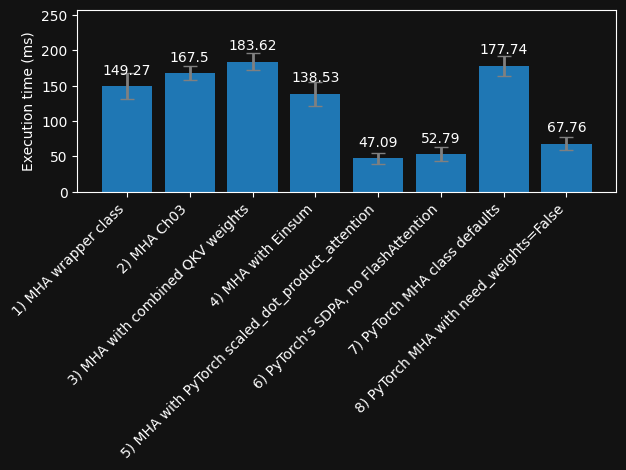

In [56]:
execution_stats = [time_pytorch_function(fn, embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="1_forward-only.pdf")